## 1️⃣ Setup & Import Libraries

In [1]:
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch

# Geospatial
import rasterio
from rasterio.plot import show

# Check PyTorch and CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("Using CPU")
    device = 'cpu'

print("\n✓ Libraries imported successfully!")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1060 6GB

✓ Libraries imported successfully!


### Configuration

In [2]:
# Paths
INFERENCE_DATA_DIR = Path('../data/inference')
MODEL_PATH = Path('../results/models/cnn_final_model.pth')
NORMALIZATION_STATS_PATH = Path('../results/data/normalization_stats.json')
OUTPUT_DIR = Path('../results/inference')

# Model configuration (MUST match training config)
CONFIG = {
    'patch_size': 3,
    'n_features': 27,
    'n_classes': 4,
    'device': device,
    'pred_batch_size': 8000,
    'pred_stride': 1,
}

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / 'rasters').mkdir(exist_ok=True)
(OUTPUT_DIR / 'plots').mkdir(exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key:25s}: {value}")

print(f"\n📁 Input data directory: {INFERENCE_DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")

Configuration:
  patch_size               : 3
  n_features               : 27
  n_classes                : 4
  device                   : cuda
  pred_batch_size          : 8000
  pred_stride              : 1

📁 Input data directory: ..\data\inference
📁 Output directory: ..\results\inference


## 2️⃣ Load Trained Model & Normalization Stats

In [3]:
from models.cnn.architecture import create_model

print("="*70)
print("LOADING TRAINED MODEL")
print("="*70)

# Check if model exists
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}\nPlease train the model first using cnn_deforestation_detection.ipynb")

# Load model checkpoint
print(f"\nLoading model from: {MODEL_PATH}")
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Check if checkpoint is a dict (with state_dict) or the model itself
if isinstance(checkpoint, dict):
    print("  Loading from checkpoint dictionary...")
    # Create model architecture first
    model = create_model(
        model_type='standard',
        patch_size=CONFIG['patch_size'],
        n_features=CONFIG['n_features'],
        n_classes=CONFIG['n_classes'],
        dropout_rate=0.7  # Same as training
    )
    # Load state dict
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
else:
    # If it's already a model object
    model = checkpoint

model = model.to(device)
model.eval()
print("✓ Model loaded successfully!")

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Load normalization stats from training
print(f"\nLoading normalization stats from: {NORMALIZATION_STATS_PATH}")
if not NORMALIZATION_STATS_PATH.exists():
    print("⚠️  Warning: Normalization stats not found!")
    print("   Will compute normalization from inference data (not recommended)")
    normalization_stats = None
else:
    with open(NORMALIZATION_STATS_PATH, 'r') as f:
        normalization_stats = json.load(f)
    print("✓ Normalization stats loaded successfully!")
    print(f"  Mean shape: {np.array(normalization_stats['mean']).shape}")
    print(f"  Std shape: {np.array(normalization_stats['std']).shape}")

print("\n" + "="*70)


LOADING TRAINED MODEL

Loading model from: ..\results\models\cnn_final_model.pth
  Loading from checkpoint dictionary...
✓ Model loaded successfully!

Model parameters:
  Total: 36,676
  Trainable: 36,676

Loading normalization stats from: ..\results\data\normalization_stats.json
⚠️  Warning: Normalization stats not found!
   Will compute normalization from inference data (not recommended)



## 3️⃣ Load New Data for Inference

In [4]:
print("="*70)
print("LOADING NEW DATA FOR INFERENCE")
print("="*70)

# Define expected file paths
s2_dir = INFERENCE_DATA_DIR / 'sentinel-2'
s1_dir = INFERENCE_DATA_DIR / 'sentinel-1'

print(f"\nSearching for Sentinel-2 data in: {s2_dir}")
print(f"Searching for Sentinel-1 data in: {s1_dir}")

# Find Sentinel-2 files (before and after)
s2_files = sorted(list(s2_dir.glob('*.tif')))
if len(s2_files) < 2:
    raise FileNotFoundError(f"Expected at least 2 Sentinel-2 files (before & after) in {s2_dir}\nFound: {len(s2_files)} files")

print(f"\n✓ Found {len(s2_files)} Sentinel-2 files:")
for f in s2_files:
    print(f"  - {f.name}")

# Find Sentinel-1 files (before and after)
s1_files = sorted(list(s1_dir.glob('*.tif')))
if len(s1_files) < 2:
    raise FileNotFoundError(f"Expected at least 2 Sentinel-1 files (before & after) in {s1_dir}\nFound: {len(s1_files)} files")

print(f"\n✓ Found {len(s1_files)} Sentinel-1 files:")
for f in s1_files:
    print(f"  - {f.name}")

# Assume first file is 'before', second is 'after'
s2_before_path = s2_files[0]
s2_after_path = s2_files[1]
s1_before_path = s1_files[0]
s1_after_path = s1_files[1]

print(f"\n📅 Time period:")
print(f"  Before: {s2_before_path.stem}, {s1_before_path.stem}")
print(f"  After:  {s2_after_path.stem}, {s1_after_path.stem}")

# Load rasters
print(f"\nLoading rasters...")
with rasterio.open(s2_before_path) as src:
    s2_before = src.read()
    s2_metadata = {
        'transform': src.transform,
        'crs': src.crs,
        'bounds': src.bounds,
        'shape': (src.height, src.width)
    }
    print(f"  Sentinel-2 before: {s2_before.shape}")

with rasterio.open(s2_after_path) as src:
    s2_after = src.read()
    print(f"  Sentinel-2 after:  {s2_after.shape}")

with rasterio.open(s1_before_path) as src:
    s1_before = src.read()
    print(f"  Sentinel-1 before: {s1_before.shape}")

with rasterio.open(s1_after_path) as src:
    s1_after = src.read()
    print(f"  Sentinel-1 after:  {s1_after.shape}")

print(f"\n✓ Data loaded successfully!")
print(f"  Image dimensions: {s2_metadata['shape'][0]} x {s2_metadata['shape'][1]}")
print(f"  CRS: {s2_metadata['crs']}")
print("="*70)

LOADING NEW DATA FOR INFERENCE

Searching for Sentinel-2 data in: ..\data\inference\sentinel-2
Searching for Sentinel-1 data in: ..\data\inference\sentinel-1

✓ Found 2 Sentinel-2 files:
  - S2_2024_04_04.tif
  - S2_2025_04_04.tif

✓ Found 2 Sentinel-1 files:
  - S1_2024_04_04_matched_S2_2024_04_04.tif
  - S1_2025_04_05_matched_S2_2025_04_04.tif

📅 Time period:
  Before: S2_2024_04_04, S1_2024_04_04_matched_S2_2024_04_04
  After:  S2_2025_04_04, S1_2025_04_05_matched_S2_2025_04_04

Loading rasters...
  Sentinel-2 before: (7, 10919, 12549)
  Sentinel-2 after:  (7, 10919, 12549)
  Sentinel-1 before: (2, 10919, 12549)
  Sentinel-1 after:  (2, 10919, 12549)

✓ Data loaded successfully!
  Image dimensions: 10919 x 12549
  CRS: EPSG:32648


## 4️⃣ Extract Features (Same as Training)

**CRITICAL**: Must use the same 27 features as training!

In [5]:
from core.feature_extraction import FeatureExtraction

print("="*70)
print("FEATURE EXTRACTION")
print("="*70)

print("\nExtracting features (must match training features)...")
extractor = FeatureExtraction()

feature_stack, valid_mask = extractor.extract_features(
    s2_before, s2_after,
    s1_before, s1_after
)

print(f"\n✓ Feature extraction completed!")
print(f"  Feature stack shape: {feature_stack.shape}")
print(f"  Expected features: {CONFIG['n_features']}")
print(f"  Valid pixels: {valid_mask.sum():,} / {valid_mask.size:,} ({valid_mask.sum()/valid_mask.size*100:.2f}%)")

# Verify feature count
if feature_stack.shape[0] != CONFIG['n_features']:
    raise ValueError(f"Feature mismatch! Expected {CONFIG['n_features']}, got {feature_stack.shape[0]}")

print("\n✓ Feature count verified!")
print("="*70)

2025-11-20 16:15:56 - core.feature_extraction - INFO - 
2025-11-20 16:15:56 - core.feature_extraction - INFO - STEP 3: FEATURE EXTRACTION
2025-11-20 16:15:56 - core.feature_extraction - INFO - ======================================================================
2025-11-20 16:15:56 - core.feature_extraction - INFO - 
Input dimensions: 10919 x 12549
2025-11-20 16:15:56 - core.feature_extraction - INFO - 
Creating valid pixel mask (relaxed for cloud coverage)...


FEATURE EXTRACTION

Extracting features (must match training features)...


2025-11-20 16:16:02 - core.feature_extraction - INFO -   ✓ Total valid pixels: 16,246,850 / 137,022,531 (11.86%)
2025-11-20 16:16:02 - core.feature_extraction - INFO -   ✓ Pixels with S2 data: 13,736,943 (10.03%)
2025-11-20 16:16:02 - core.feature_extraction - INFO -   ✓ S1-only pixels (cloudy): 2,509,907 (1.83%)
2025-11-20 16:16:02 - core.feature_extraction - INFO - 
Extracting Sentinel-2 features...
2025-11-20 16:16:05 - core.feature_extraction - INFO -   - Imputing S2 values for cloudy pixels using median...
2025-11-20 16:16:11 - core.feature_extraction - INFO -   - Adding S2 Before bands (7 features)
2025-11-20 16:16:11 - core.feature_extraction - INFO -   - Adding S2 After bands (7 features)
2025-11-20 16:16:11 - core.feature_extraction - INFO -   - Calculating S2 Delta (7 features)
2025-11-20 16:16:13 - core.feature_extraction - INFO -   ✓ Total S2 features: 21
2025-11-20 16:16:13 - core.feature_extraction - INFO - 
Extracting Sentinel-1 features...
2025-11-20 16:16:13 - core.fea


✓ Feature extraction completed!
  Feature stack shape: (27, 10919, 12549)
  Expected features: 27
  Valid pixels: 16,246,850 / 137,022,531 (11.86%)

✓ Feature count verified!


## 5️⃣ Predict Full Raster

**Apply trained model to entire study area**

In [ ]:
from models.cnn.predictor import RasterPredictor

print("="*70)
print("PREDICTING FULL RASTER")
print("="*70)

# Create predictor
print("\nInitializing RasterPredictor...")
predictor = RasterPredictor(
    model=model,
    device=CONFIG['device'],
    patch_size=CONFIG['patch_size'],
    batch_size=CONFIG['pred_batch_size']
)

print(f"  Device: {CONFIG['device']}")
print(f"  Patch size: {CONFIG['patch_size']}x{CONFIG['patch_size']}")
print(f"  Batch size: {CONFIG['pred_batch_size']:,}")
print(f"  Stride: {CONFIG['pred_stride']}")

# Predict
print(f"\n🔮 Starting prediction...")
print("   (This may take several minutes depending on image size)\n")

prediction_start = time.time()

multiclass_map = predictor.predict_raster(
    feature_stack=feature_stack,
    valid_mask=valid_mask,
    stride=CONFIG['pred_stride'],
    normalize=True,
    normalization_stats=normalization_stats,  # Use training stats
    temperature=1.0,
    compute_probs=False  # Disable probability computation to save memory/time
)

prediction_time = time.time() - prediction_start

print(f"\n✓ Prediction completed in {prediction_time:.2f} seconds ({prediction_time/60:.2f} minutes)")
print(f"  Output shape: {multiclass_map.shape}")
print("="*70)

2025-11-20 16:16:37 - models.cnn.predictor - INFO - RasterPredictor initialized on device: cuda
2025-11-20 16:16:37 - models.cnn.predictor - INFO - 
2025-11-20 16:16:37 - models.cnn.predictor - INFO - PREDICTING FULL RASTER WITH CNN
2025-11-20 16:16:37 - models.cnn.predictor - INFO - ======================================================================
2025-11-20 16:16:37 - models.cnn.predictor - INFO - Raster shape: 10919 x 12549
2025-11-20 16:16:37 - models.cnn.predictor - INFO - Patch size: 3x3
2025-11-20 16:16:37 - models.cnn.predictor - INFO - Stride: 1
2025-11-20 16:16:37 - models.cnn.predictor - INFO - Batch size: 8000
2025-11-20 16:16:37 - models.cnn.predictor - INFO - Temperature: 1.0 (normal)
2025-11-20 16:16:37 - models.cnn.predictor - INFO - 
Extracting patches...
2025-11-20 16:16:37 - models.cnn.patch_extractor - INFO - 
Extracting patches for full raster prediction...
2025-11-20 16:16:37 - models.cnn.patch_extractor - INFO - Raster shape: 10919 x 12549
2025-11-20 16:16:3

PREDICTING FULL RASTER

Initializing RasterPredictor...
  Device: cuda
  Patch size: 3x3
  Batch size: 8,000
  Stride: 1

🔮 Starting prediction...
   (This may take several minutes depending on image size)



2025-11-20 16:16:38 - models.cnn.patch_extractor - INFO - Total potential patches: 136,975,599
2025-11-20 16:16:39 - models.cnn.patch_extractor - INFO - After center mask filter: 16,246,850
2025-11-20 16:16:39 - models.cnn.patch_extractor - INFO - Processing 325 chunks of 50,000 patches...
2025-11-20 16:16:59 - models.cnn.patch_extractor - INFO -   Processed 10/325 chunks...
2025-11-20 16:17:19 - models.cnn.patch_extractor - INFO -   Processed 20/325 chunks...
2025-11-20 16:17:39 - models.cnn.patch_extractor - INFO -   Processed 30/325 chunks...
2025-11-20 16:17:59 - models.cnn.patch_extractor - INFO -   Processed 40/325 chunks...
2025-11-20 16:18:19 - models.cnn.patch_extractor - INFO -   Processed 50/325 chunks...
2025-11-20 16:18:39 - models.cnn.patch_extractor - INFO -   Processed 60/325 chunks...
2025-11-20 16:18:59 - models.cnn.patch_extractor - INFO -   Processed 70/325 chunks...
2025-11-20 16:19:19 - models.cnn.patch_extractor - INFO -   Processed 80/325 chunks...
2025-11-20 16


✓ Prediction completed in 945.45 seconds (15.76 minutes)
  Output shape: (10919, 12549)


## 6️⃣ Save Results

In [ ]:
print("="*70)
print("SAVING RESULTS")
print("="*70)

# Generate output filename with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

multiclass_output_path = OUTPUT_DIR / 'rasters' / f'prediction_multiclass_{timestamp}.tif'

print(f"\nSaving prediction rasters...")

# Save multiclass map only (no probabilities)
predictor.save_rasters(
    reference_metadata=s2_metadata,
    multiclass_path=multiclass_output_path,
    multiclass_probs_path=None  # Do not save probability map
)

print(f"\n✓ Rasters saved successfully!")
print(f"  Multiclass map: {multiclass_output_path.name}")

# Save metadata
metadata_output = {
    'timestamp': timestamp,
    'input_files': {
        's2_before': s2_before_path.name,
        's2_after': s2_after_path.name,
        's1_before': s1_before_path.name,
        's1_after': s1_after_path.name
    },
    'model_path': str(MODEL_PATH),
    'image_shape': s2_metadata['shape'],
    'crs': str(s2_metadata['crs']),
    'prediction_time_seconds': prediction_time,
    'config': CONFIG
}

metadata_path = OUTPUT_DIR / f'metadata_{timestamp}.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata_output, f, indent=2)

print(f"  Metadata: {metadata_path.name}")
print("="*70)

2025-11-20 16:32:22 - models.cnn.predictor - INFO - 
Saving output rasters...


SAVING RESULTS

Saving prediction rasters...


2025-11-20 16:32:23 - models.cnn.predictor - INFO -   Multiclass raster saved: ..\results\inference\rasters\prediction_multiclass_20251120_163222.tif
2025-11-20 16:32:43 - models.cnn.predictor - INFO -   4-band multiclass probabilities raster saved: ..\results\inference\rasters\prediction_probs_20251120_163222.tif



✓ Rasters saved successfully!
  Multiclass map: prediction_multiclass_20251120_163222.tif
  Probability map: prediction_probs_20251120_163222.tif
  Metadata: metadata_20251120_163222.json


## 7️⃣ Classification Statistics

In [8]:
print("="*70)
print("CLASSIFICATION STATISTICS (4-Class)")
print("="*70)

# Count pixels for each class
class_0_pixels = np.sum(multiclass_map[valid_mask] == 0)  # Forest Stable
class_1_pixels = np.sum(multiclass_map[valid_mask] == 1)  # Deforestation
class_2_pixels = np.sum(multiclass_map[valid_mask] == 2)  # Non-forest
class_3_pixels = np.sum(multiclass_map[valid_mask] == 3)  # Reforestation
total_valid = np.sum(valid_mask)

print(f"\nTotal pixels:")
print(f"  Valid pixels:          {total_valid:,}")
print(f"  Invalid pixels:        {np.sum(~valid_mask):,}")

print(f"\n4-Class breakdown:")
print(f"  Class 0 - Forest Stable:    {class_0_pixels:,} ({class_0_pixels/total_valid*100:.2f}%)")
print(f"  Class 1 - Deforestation:    {class_1_pixels:,} ({class_1_pixels/total_valid*100:.2f}%)")
print(f"  Class 2 - Non-forest:       {class_2_pixels:,} ({class_2_pixels/total_valid*100:.2f}%)")
print(f"  Class 3 - Reforestation:    {class_3_pixels:,} ({class_3_pixels/total_valid*100:.2f}%)")

print(f"\nArea estimates (10m resolution):")
print(f"  Forest Stable area:    {class_0_pixels * 100 / 10000:.2f} ha")
print(f"  Deforestation area:    {class_1_pixels * 100 / 10000:.2f} ha")
print(f"  Non-forest area:       {class_2_pixels * 100 / 10000:.2f} ha")
print(f"  Reforestation area:    {class_3_pixels * 100 / 10000:.2f} ha")
print(f"  Total valid area:      {total_valid * 100 / 10000:.2f} ha")

# Save statistics
stats_output = {
    'timestamp': timestamp,
    'total_pixels': int(total_valid),
    'classes': {
        'forest_stable': {'pixels': int(class_0_pixels), 'percent': float(class_0_pixels/total_valid*100), 'area_ha': float(class_0_pixels * 100 / 10000)},
        'deforestation': {'pixels': int(class_1_pixels), 'percent': float(class_1_pixels/total_valid*100), 'area_ha': float(class_1_pixels * 100 / 10000)},
        'non_forest': {'pixels': int(class_2_pixels), 'percent': float(class_2_pixels/total_valid*100), 'area_ha': float(class_2_pixels * 100 / 10000)},
        'reforestation': {'pixels': int(class_3_pixels), 'percent': float(class_3_pixels/total_valid*100), 'area_ha': float(class_3_pixels * 100 / 10000)}
    }
}

stats_path = OUTPUT_DIR / f'statistics_{timestamp}.json'
with open(stats_path, 'w') as f:
    json.dump(stats_output, f, indent=2)

print(f"\n✓ Statistics saved to: {stats_path.name}")
print("="*70)

CLASSIFICATION STATISTICS (4-Class)

Total pixels:
  Valid pixels:          16,246,850
  Invalid pixels:        120,775,681

4-Class breakdown:
  Class 0 - Forest Stable:    12,071,691 (74.30%)
  Class 1 - Deforestation:    728,215 (4.48%)
  Class 2 - Non-forest:       2,952,854 (18.17%)
  Class 3 - Reforestation:    494,090 (3.04%)

Area estimates (10m resolution):
  Forest Stable area:    120716.91 ha
  Deforestation area:    7282.15 ha
  Non-forest area:       29528.54 ha
  Reforestation area:    4940.90 ha
  Total valid area:      162468.50 ha

✓ Statistics saved to: statistics_20251120_163222.json


## 8️⃣ Visualization

In [9]:
from core.visualization import Visualizer

print("Creating visualization...\n")

# Initialize Visualizer
visualizer = Visualizer()

# Plot 4-class multiclass map
plot_path = OUTPUT_DIR / 'plots' / f'prediction_map_{timestamp}.png'
visualizer.plot_multiclass_map(
    multiclass_map=multiclass_map,
    valid_mask=valid_mask,
    output_path=plot_path
)

print(f"\n✓ Visualization saved to: {plot_path.name}")

2025-11-20 16:32:44 - core.visualization - INFO - 
Plotting 4-class multiclass map...


Creating visualization...



2025-11-20 16:33:38 - core.visualization - INFO -   ✓ Saved to: ..\results\inference\plots\prediction_map_20251120_163222.png



✓ Visualization saved to: prediction_map_20251120_163222.png


### Class Distribution Bar Chart

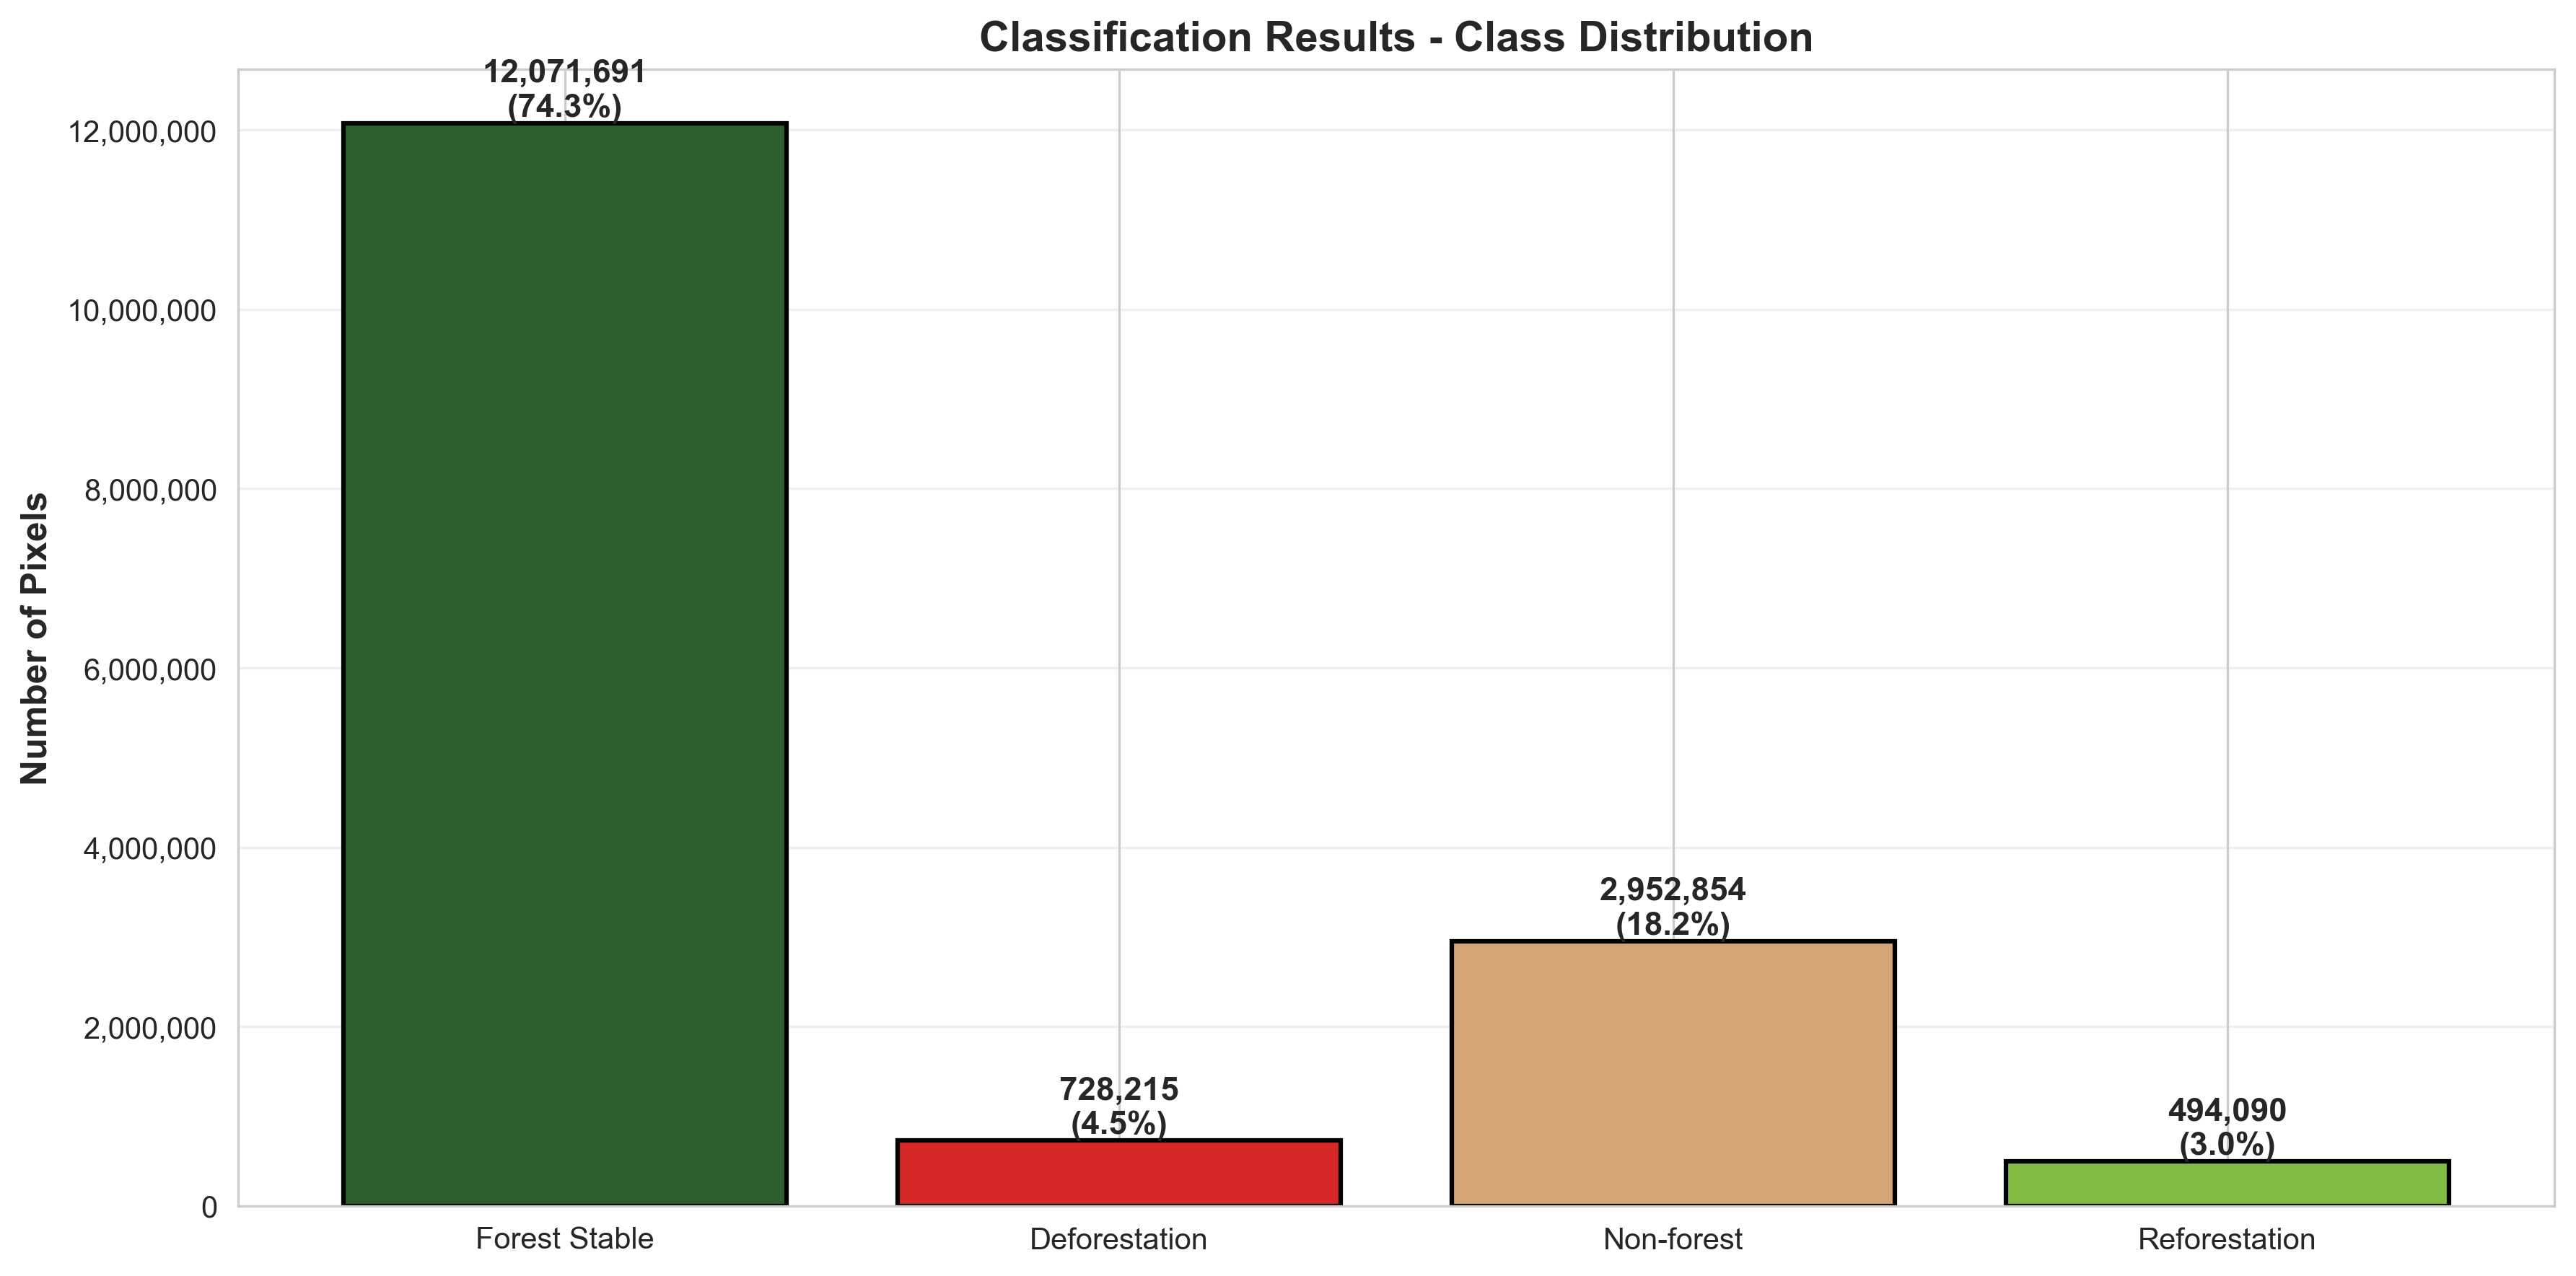

✓ Bar chart saved to: class_distribution_20251120_163222.png


In [10]:
# Create bar chart for class distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

class_names = ['Forest Stable', 'Deforestation', 'Non-forest', 'Reforestation']
class_counts = [class_0_pixels, class_1_pixels, class_2_pixels, class_3_pixels]
class_colors = ['#2d5f2e', '#d62728', '#d4a574', '#7fbc41']

bars = ax.bar(class_names, class_counts, color=class_colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/total_valid*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Number of Pixels', fontsize=12, fontweight='bold')
ax.set_title('Classification Results - Class Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_axisbelow(True)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()

# Save
bar_chart_path = OUTPUT_DIR / 'plots' / f'class_distribution_{timestamp}.png'
plt.savefig(bar_chart_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Bar chart saved to: {bar_chart_path.name}")

## 📊 Summary

In [ ]:
print("\n" + "="*70)
print("INFERENCE COMPLETED SUCCESSFULLY!")
print("="*70)

print("\n📅 INPUT DATA:")
print(f"  Sentinel-2 before: {s2_before_path.name}")
print(f"  Sentinel-2 after:  {s2_after_path.name}")
print(f"  Sentinel-1 before: {s1_before_path.name}")
print(f"  Sentinel-1 after:  {s1_after_path.name}")

print("\n🤖 MODEL:")
print(f"  Model path: {MODEL_PATH}")
print(f"  Device: {CONFIG['device']}")
print(f"  Parameters: {total_params:,}")

print("\n📊 RESULTS:")
print(f"  Total area classified: {total_valid * 100 / 10000:.2f} ha")
print(f"  Forest Stable:    {class_0_pixels * 100 / 10000:8.2f} ha ({class_0_pixels/total_valid*100:.1f}%)")
print(f"  Deforestation:    {class_1_pixels * 100 / 10000:8.2f} ha ({class_1_pixels/total_valid*100:.1f}%)")
print(f"  Non-forest:       {class_2_pixels * 100 / 10000:8.2f} ha ({class_2_pixels/total_valid*100:.1f}%)")
print(f"  Reforestation:    {class_3_pixels * 100 / 10000:8.2f} ha ({class_3_pixels/total_valid*100:.1f}%)")

print("\n⏱️  EXECUTION TIME:")
print(f"  Prediction: {prediction_time:.2f} seconds ({prediction_time/60:.2f} minutes)")

print("\n📁 OUTPUT FILES:")
print(f"  Rasters:")
print(f"    - {multiclass_output_path.name}")
print(f"  Data:")
print(f"    - {metadata_path.name}")
print(f"    - {stats_path.name}")
print(f"  Plots:")
print(f"    - {plot_path.name}")
print(f"    - {bar_chart_path.name}")

print("\n📍 OUTPUT LOCATION:")
print(f"  {OUTPUT_DIR.absolute()}")

print("\n✅ All files saved successfully!")
print("="*70 + "\n")


INFERENCE COMPLETED SUCCESSFULLY!

📅 INPUT DATA:
  Sentinel-2 before: S2_2024_04_04.tif
  Sentinel-2 after:  S2_2025_04_04.tif
  Sentinel-1 before: S1_2024_04_04_matched_S2_2024_04_04.tif
  Sentinel-1 after:  S1_2025_04_05_matched_S2_2025_04_04.tif

🤖 MODEL:
  Model path: ..\results\models\cnn_final_model.pth
  Device: cuda
  Parameters: 36,676

📊 RESULTS:
  Total area classified: 162468.50 ha
  Forest Stable:    120716.91 ha (74.3%)
  Deforestation:     7282.15 ha (4.5%)
  Non-forest:       29528.54 ha (18.2%)
  Reforestation:     4940.90 ha (3.0%)

⏱️  EXECUTION TIME:
  Prediction: 945.45 seconds (15.76 minutes)

📁 OUTPUT FILES:
  Rasters:
    - prediction_multiclass_20251120_163222.tif
    - prediction_probs_20251120_163222.tif
  Data:
    - metadata_20251120_163222.json
    - statistics_20251120_163222.json
  Plots:
    - prediction_map_20251120_163222.png
    - class_distribution_20251120_163222.png

📍 OUTPUT LOCATION:
  d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebook\..\r